## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0
sys

'Combined'

In [4]:
%%time
datasets_input = []
for l in livetimes:
    datasets_i  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                   livetime = f"{l}-hr",
                                            parameters = None)
    datasets_input.append(datasets_i)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.01-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.021544346900318832-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.046415888336127774-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.1-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.21544346900318834-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.46415888336127775-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simula

## Datasets

In [5]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        
    if sys == "E_reco":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
        dataset_asimov_N.irf_model.parameters['norm'].frozen = True
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

    if sys == "Combined":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    
    if sys == "BKG":
        
        # piece wise model
        # remove old bkg model
        setup.set_up_bkg_sys_V( breake = 10,
                            index1 = 2,
                            index2 = 1.5, 
                            magnitude = magnitude )
        
        dataset_asimov, dataset_asimov_N = setup.run()
        
        setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
        setup.set_piecewise_bkg_model(dataset_asimov_N)
        # energy of the following parameters smaller than ethrshold
        dataset_asimov_N.background_model.parameters['norm0'].frozen = True
        dataset_asimov_N.background_model.parameters['norm1'].frozen = True
        dataset_asimov_N.background_model.parameters['norm2'].frozen = True
        dataset_asimov_N.background_model.parameters['norm3'].frozen = True
        setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
        
       
    return dataset_asimov_N, dataset_asimov

In [6]:
datasets_N = []
datasets = []
for d in datasets_input:
    dataset_asimov_N, dataset_asimov = set_up(d)
    datasets_N.append(dataset_asimov_N)
    datasets.append(dataset_asimov)

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1154: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals ((data - model) / sqrt(model))'>

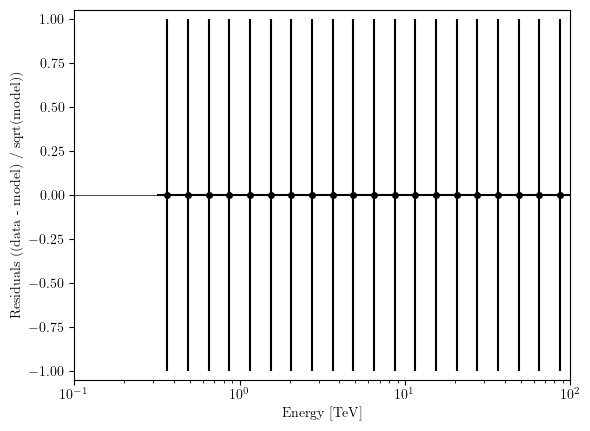

In [7]:
datasets_N[0].plot_residuals_spectral(method = 'diff/sqrt(model)')

In [8]:
%%time
fitting = 0
if fitting:
    for i, d in enumerate(datasets):
        print(i)
        fit_cor = Fit(store_trace=0)
        result_cor = fit_cor.run(d)
        print(result_cor)
        print("saving")
        path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets):
        print(i)
        path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
        datasets[i].models = Models.read(path)


read
0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 266 ms, sys: 6.91 ms, total: 273 ms
Wall time: 288 ms


In [9]:
%%time
fitting_N = 0

if fitting_N:
    
    for i, d in enumerate(datasets_N):
        if i >1:
            print(i)

            fit_cor = Fit(store_trace=0)
            minuit_opts = {"tol": 0.001, "strategy": 1}
            fit_cor.backend = "minuit"
            fit_cor.optimize_opts = minuit_opts
            result_cor = fit_cor.run(d)
            print(result_cor)
            print("saving")
            path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}.yml'
            d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets_N):
        print(i)
        path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}.yml'
        print(path)
        datasets_N[i] = Dataset_load.load_dataset_N(d, path,bkg_sys = False)        
        datasets_N[i].models.parameters['tilt'].frozen = False 
    

#39min 32

read
0
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_0.01.yml
1
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_0.021544346900318832.yml
2
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_0.046415888336127774.yml
3
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_0.1.yml
4
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_0.21544346900318834.yml
5
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_0.46415888336127775.yml
6
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_1.0.yml
7
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_2.154434690031884.yml
8
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_4.641588833612778.yml
9
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_10.0.yml
10
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_21.544346900318832.yml
11
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_46.41588833612777.yml
12
../Combined_PKSflare_crab_log/data/0_model_nui_livetime_100.0.yml
CPU tim

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1154: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1154: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1154: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1154: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1154: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1154: RuntimeWarning: invalid value encountered in true_divide

(-5.0, 5.0)

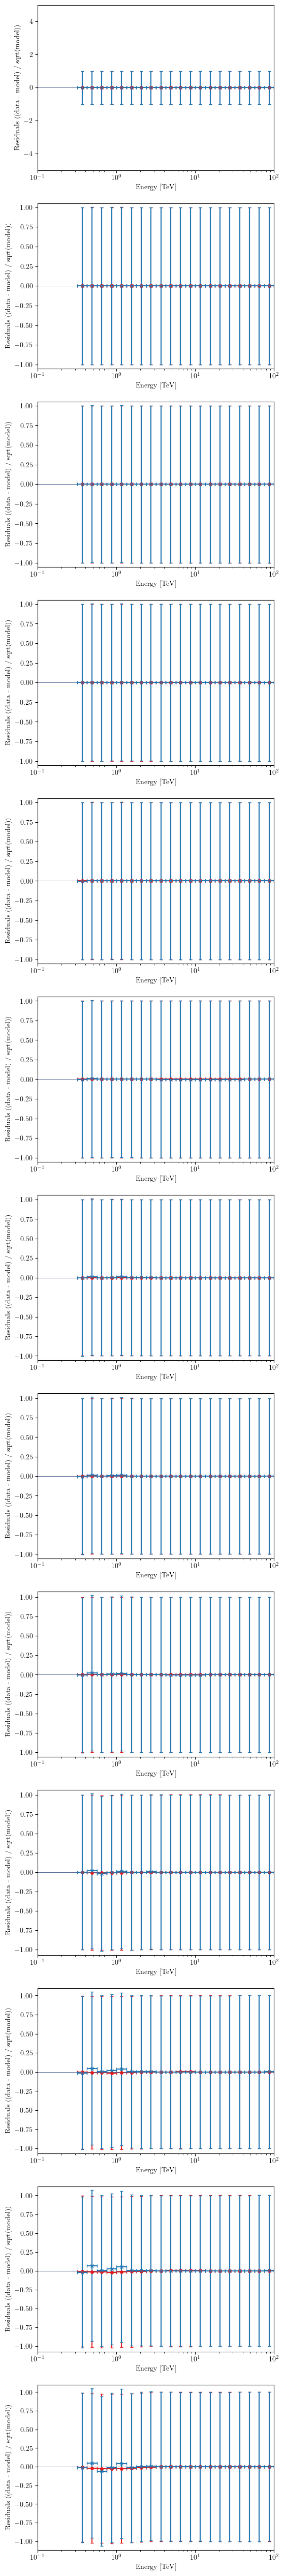

In [10]:
def plot_residuals_spec():
    fig,axs = plt.subplots(len(datasets), 1, figsize = (6, 5 * len(datasets)))
    if len(datasets) ==1:
        axs = np.array([axs])
    axs= axs.flatten()
    
    energy_power = 2
    for i, d in enumerate(datasets):
        ax = axs[i]
        live = livetimes[i]
        dataset = datasets[i]
        dataset_N = datasets_N[i]
        dataset.plot_residuals_spectral(ax  = ax, color = awo[0], method = 'diff/sqrt(model)',
                                       capsize = 2)
        dataset_N.plot_residuals_spectral(ax  = ax, color = aw[0], method = 'diff/sqrt(model)',
                                         capsize = 2, marker = 'x')
    return axs
        
axs = plot_residuals_spec()
axs[0].set_ylim(-5, 5)

In [11]:
labels = [str(int(l)) for l in livetimes]
models_list_irf = [ d.irf_model for d in datasets_N]
models_list_piecebkg = [ d.background_model for d in datasets_N]

pars =   [('bias', 'resolution'), ('norm', 'tilt')]

colors_default =  plt.rcParams['axes.prop_cycle'].by_key()['color'] 
colors_default = colors_default* 5

In [12]:
models_list_irf[0]

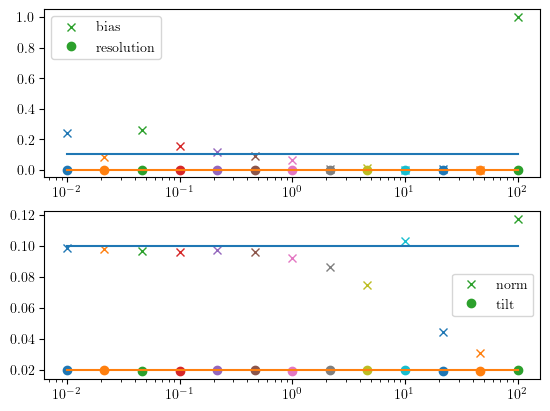

In [13]:
i = 0
if models_list_irf[0] is not None:
    fig,axs = plt.subplots(2,1)
    for l, m in zip(livetimes, models_list_irf):
        axs[0].plot(l, m.parameters[pars[0][0]].error, 'x', label = "bias", color = colors_default[i])
        axs[0].plot(l, m.parameters[pars[0][1]].error, 'o' , label = "resolution", color = colors_default[i])
        axs[1].plot(l, m.parameters[pars[1][0]].error, 'x' , label = "norm", color = colors_default[i])
        axs[1].plot(l, m.parameters[pars[1][1]].error, 'o' , label = "tilt", color = colors_default[i])
        i +=1


    axs[0].plot([livetimes[0],livetimes[-1]], [bias, bias])
    axs[0].plot([livetimes[0],livetimes[-1]], [resolution, resolution])
    axs[1].plot([livetimes[0],livetimes[-1]], [norm, norm])
    axs[1].plot([livetimes[0],livetimes[-1]], [tilt, tilt])  

    for a in axs:
        a.set_xscale("log")
        a.legend()


        from collections import OrderedDict

        handles, labels = a.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        a.legend(by_label.values(), by_label.keys())

    #axs[0].set_ylim(-0.01, 0.2)
    fig.savefig(f'../{folder}/plots/{nbidx}_irf_fit_results.pdf')

else:
    for m in models_list_piecebkg:
        if "norm0" in m.parameters.names:
            plt.plot(m.spectral_model.energy.value, m.spectral_model.norms)
            plt.xscale("log")
            plt.xlabel("Energy [TeV]")
            plt.ylabel("Fitted bkg sys")

In [14]:
print(datasets_N[7].models)

DatasetModels

Component 0: SkyModel

  Name                      : g2YhMcrW
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.85e-11   +/- 7.0e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                         :      2.510   +/-    0.78             
    beta                          :      0.240   +/-    0.26             
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : kR0S1hkg-bkg
  Datasets names            : ['kR0S1hkg']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.01             
    tilt                          :  

In [15]:
np.sqrt(0.06/2.51 **2 + 0.02 ** 2)

0.09961756047318812

In [16]:
print(datasets[7].models[0])

SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.85e-11   +/- 1.8e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                         :      2.510   +/-    0.06             
    beta                          :      0.240   +/-    0.06             
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         




<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2 * dnde [$\\mathrm{TeV\\,s^{-1}\\,cm^{-2}}$]'>

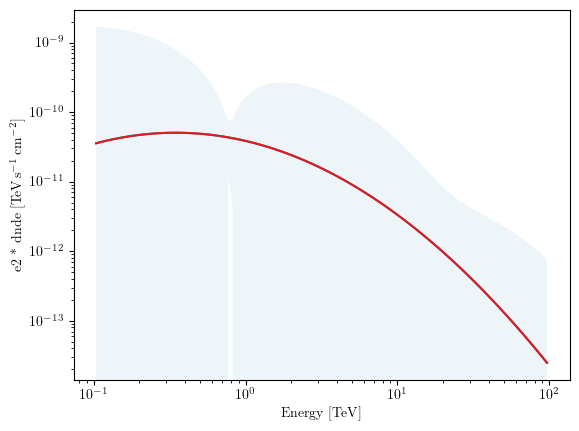

In [17]:
ax = datasets_N[0].models[0].spectral_model.plot((0.1, 100) *u.TeV, energy_power = 2,
                                                     color = aw[0], ) \

datasets_N[0].models[0].spectral_model.plot_error((0.1, 100) *u.TeV, energy_power = 2,
                                                     facecolor = aw[1], ax = ax) 

datasets[0].models[0].spectral_model.plot((0.1, 100) *u.TeV, energy_power = 2,
                                                     color = awo[0], ax = ax) 

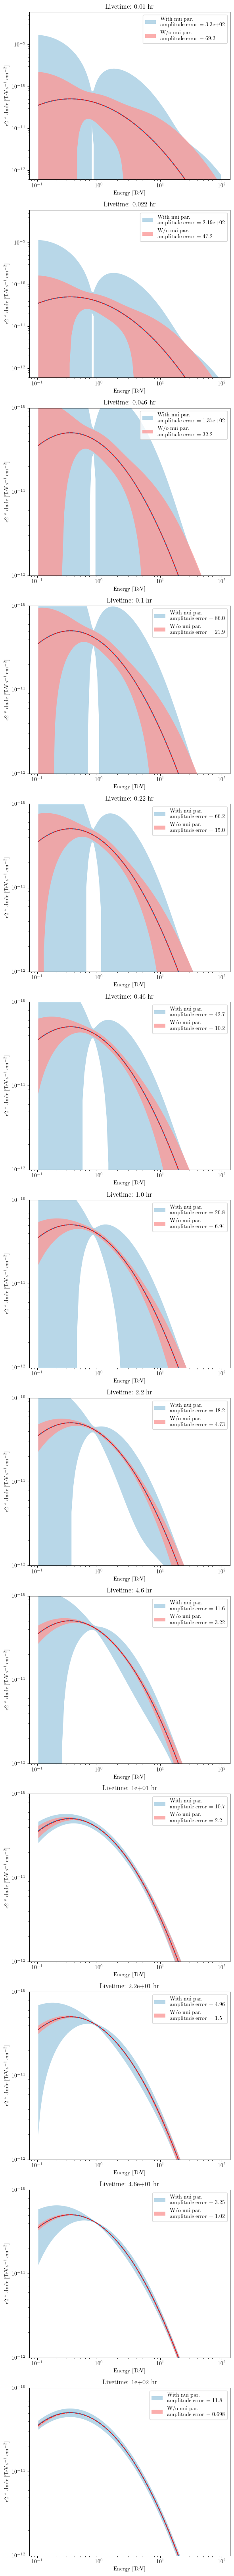

In [18]:
def plot_spectra_empty():
    fig,axs = plt.subplots(len(datasets), 1, figsize = (6, 5 * len(datasets)))
    if len(datasets) ==1:
        axs = np.array([axs])
    axs= axs.flatten()
    
    energy_power = 2
    for i, d in enumerate(datasets):
        ax = axs[i]
        live = livetimes[i]
        dataset = datasets[i]
        dataset_N = datasets_N[i]
        dataset_N.models[0].spectral_model.plot((0.1, 100) *u.TeV, energy_power = energy_power,
                                                     color = aw[0], ax = ax)   
        
        par = dataset_N.models[0].parameters['amplitude']
        per = par.error /par.value
        dataset_N.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= aw[1], alpha = 0.8, 
                                                     label = f'With nui par.\n amplitude error =  {per*100:.3}% ')
        dataset.models[0].spectral_model.plot((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   color= awo[0], linestyle = 'dashed')
        par = dataset.models[0].parameters['amplitude']
        per = par.error /par.value
        dataset.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= awo[1], alpha = 0.8,
                                                   label = f'W/o nui par.\n amplitude error =  {per*100:.3}%')
        ax.set_title(f"Livetime: {float(live):.2} hr")
        ax.set_ylim(1e-12, 1e-10)

        if i <2:
            ax.set_ylim(6e-13, 6e-9)
            
        ax.legend()
    plt.tight_layout()
    return fig
        
fig = plot_spectra_empty()
fig.savefig(f'../{folder}/plots/{nbidx}_spectra.pdf')

In [19]:
compute = 0
if compute:
    stat_0 = []
    for d in datasets:
        s = d.stat_sum()
        with d.models.parameters.restore_status():
            d.models.parameters['amplitude'].value = 0 
            d.models[0].parameters.freeze_all()
            bkg = FoVBackgroundModel(dataset_name=d.name)
            d.models= Models([bkg])
            fit = Fit()
            result= fit.optimize(d)
            print(result)
            stat_0.append(np.sqrt( d.stat_sum() - s))
        print(stat_0)
    np.savetxt( f'../{folder}/data/0_sqrtts.txt',  np.array(stat_0))
else:
    stat_0 = np.loadtxt( f'../{folder}/data/0_sqrtts.txt')
stat_0

array([  3.99426124,   5.86277373,   8.60537498,  12.63096309,
        18.53971838,  27.21258506,  39.94261242,  58.62773725,
        86.0537498 , 126.3096217 , 185.39716957, 272.12582989,
       399.42609405])

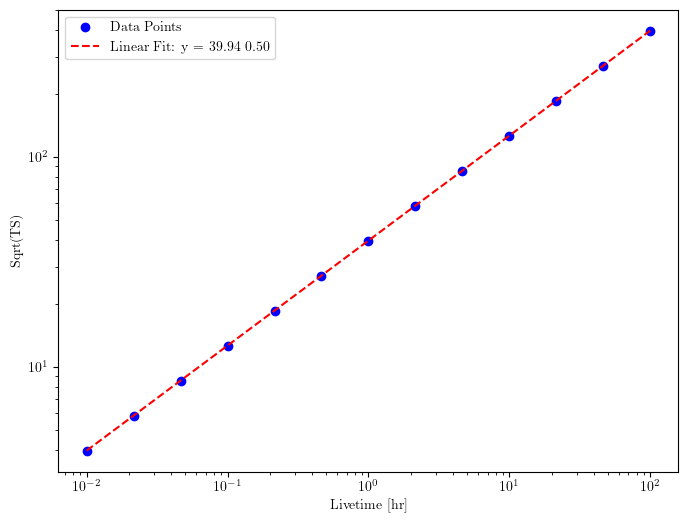

For a desired sig of 5.00, the corresponding livetime is approximately 0.015670.
For a desired sig of 50.00, the corresponding livetime is approximately 1.566993.


In [20]:
from scipy.optimize import curve_fit
if len(stat_0)>1:
    # Given data
    x_values =livetimes
    y_values =stat_0

    # Define the linear function
    def linear_fit(x, a, b):
        return a * x**b

    # Perform the curve fit
    params, covariance = curve_fit(linear_fit, x_values, y_values)
    a_fit, b_fit = params

    # Create a log-log plot
    plt.figure(figsize=(8, 6))
    plt.loglog(x_values, y_values, 'bo', label='Data Points')
    plt.loglog(x_values, linear_fit(x_values, a_fit, b_fit), 'r--', label=f'Linear Fit: y = {a_fit:.2f} {b_fit:.2f}')
    plt.xlabel('Livetime [hr]')
    plt.ylabel('Sqrt(TS)')
    plt.legend()
    plt.show()


    def compute_x_for_given_y(y_value, a, b):
        """
        Computes the x value for a given y value using the linear fit equation.

        Args:
            y_value (float): The desired y value.
            a (float): Coefficient 'a' from the linear fit equation.
            b (float): Coefficient 'b' from the linear fit equation.

        Returns:
            float: The corresponding x value.
        """
        # Solve for x using the inverse of the linear fit equation
        x_value = (y_value / a) ** (1 / b)
        return x_value

    # Example usage
    desired_y = 5  # Replace with your desired y value
    computed_5 = compute_x_for_given_y(desired_y, a_fit, b_fit)
    print(f"For a desired sig of {desired_y:.2f}, the corresponding livetime is approximately {computed_5:.6f}.")
    desired_y = 50  # Replace with your desired y value
    computed_50 = compute_x_for_given_y(desired_y, a_fit, b_fit)
    print(f"For a desired sig of {desired_y:.2f}, the corresponding livetime is approximately {computed_50:.6f}.")


In [21]:
fontsize = 14

inputvalues = {}
for p in datasets_input[0].models[0].parameters:
    inputvalues[p.name]  = p.value

def plotting(parname = "amplitude", delta = 1):
    fig = plt.figure(figsize  = (8,5))
    inputvalue = inputvalues[parname]
    
    errs = []
    errs_N = []
    livetimes_ext = np.array(livetimes).copy(); livetimes_ext2 = np.array(livetimes).copy(); 
    livetimes_ext[-1] *=1.1;
    livetimes_ext2[0:,] *=1.1; 
    livetimes_ext2 = np.insert(livetimes_ext2, 0, values =  livetimes_ext2[0]* 0.9)


    for i, d in enumerate(datasets_N):
        par = datasets[i].models[0].parameters[parname]
        val, err = par.value, par.error
        errs.append( err/ inputvalue )
        plt.errorbar(livetimes[i], val/ inputvalue, yerr =  err/ inputvalue,  fmt='x', 
                     color = awo[0])

        par = d.models[0].parameters[parname]
        val, err = par.value, par.error
        errs_N.append( err/ inputvalue)
        plt.errorbar( 1.1* livetimes[i] , val/ inputvalue, yerr = err/ inputvalue,  fmt='x', 
                     color = aw[0])

    

    errs_N = np.insert(errs_N, 0, values =  errs_N[0])
    plt.fill_between(  livetimes_ext2, 1- np.array(errs_N), 1+np.array(errs_N) 
                     ,color = aw[1], alpha = 0.8, label = '')
    plt.fill_between( livetimes_ext, 1- np.array(errs), 1+np.array(errs)
                     ,color = awo[1], alpha = 0.8, label = '')

    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = aw[0],
                 label = 'fit with systematics')
    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = awo[0], 
                 label = 'fit w/o systematics')
    ax1 = plt.gca()
    xlim = ax1.get_xlim()
    plt.hlines(1, xlim[0], xlim[1], color = 'lightgrey')
    #plt.title("Best Fit Amplitude")
    plt.legend(fontsize = fontsize)
    plt.xscale('log')
    plt.xlabel("Livetime [hr]", fontsize = fontsize)
    plt.ylabel(f"Best-fit {parname} \n[Input]", fontsize = fontsize)

    ax2 = ax1.twiny()
    ax2.set_xscale("log")
    npred = [d.npred_signal().data.sum() for d in datasets]
    
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(livetimes)
    clabels = [ f'{int(c)}' for c in npred]
    ax2.set_xticklabels(clabels)
    ax2.set_xlabel(r"Signal Counts", fontsize = fontsize)
    plt.tight_layout()
    ax = plt.gca()
    ax.set_ylim(1- delta, 1. + delta)
    ax.vlines(computed_50, ax.get_ylim()[0], ax.get_ylim()[1], color = 'grey',linestyle =  'dashed')
    ax.vlines(computed_5, ax.get_ylim()[0], ax.get_ylim()[1], color = 'grey',linestyle =  'dotted')
    ax.text(computed_50*1.02, ax.get_ylim()[1]*0.9 ,"50 $\sigma$", color = 'grey', fontsize = fontsize)
    ax.text(computed_5*1.02, ax.get_ylim()[1]*0.9 ,"5 $\sigma$", color = 'grey', fontsize = fontsize)
    return fig

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


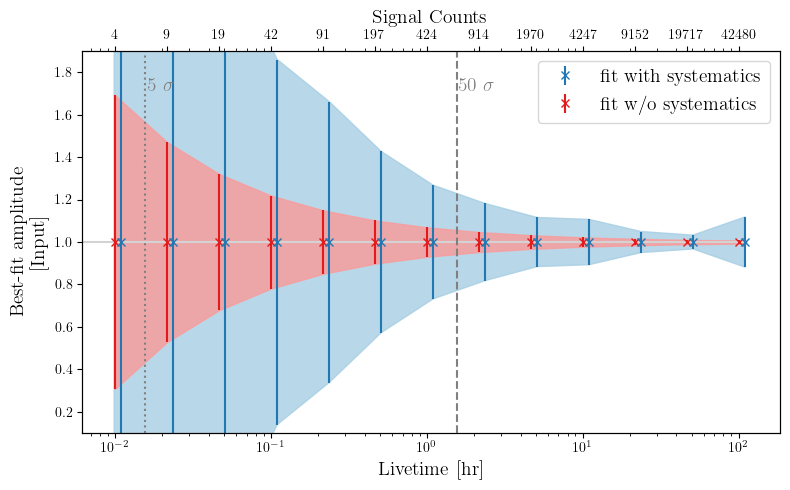

In [22]:
fig = plotting(parname = "amplitude", delta = 0.9)
fontsize = 14
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_amplitude.svg')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_amplitude.pdf')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_amplitude.png')

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


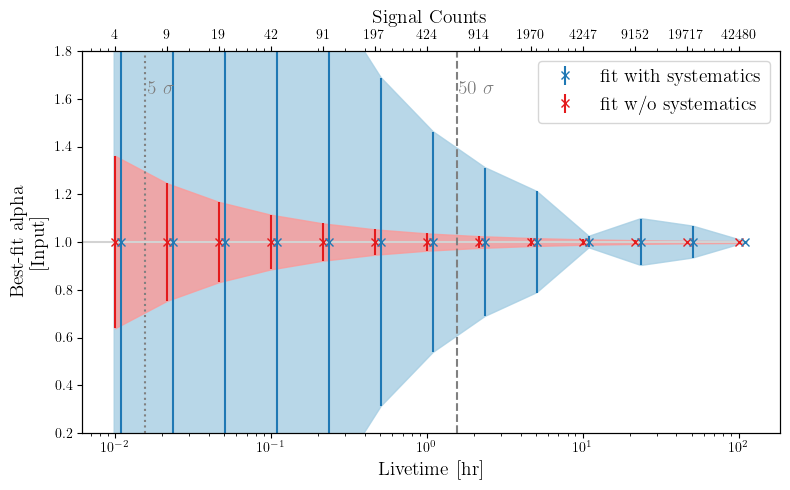

In [23]:
parname = "alpha"
fig = plotting(parname = parname, delta = 0.8)

fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.svg')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.pdf')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.png')

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


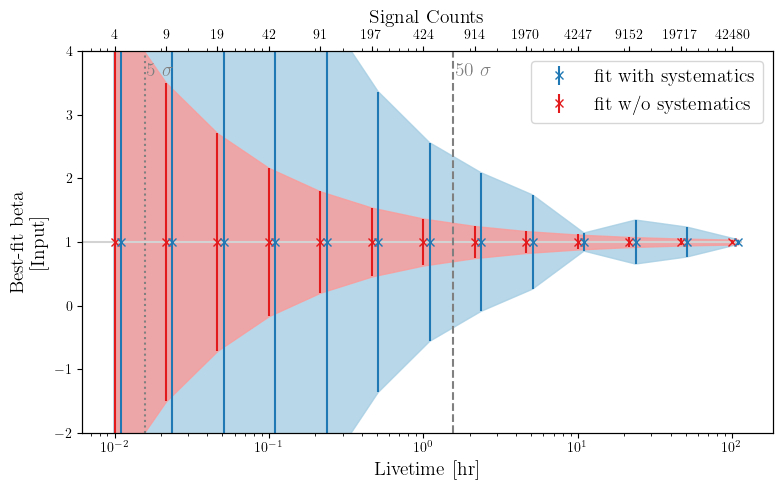

In [24]:
parname = "beta"
fig = plotting(parname = parname, delta = 3)


fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.svg')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.pdf')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.png')

## RND Fluxpoints

In [25]:
for i, d in enumerate(datasets):
    l = livetimes[i]
    print()
    print(l)
    dataset = datasets[i]
    dataset_N = datasets_N[i]
    parameters = dataset.models[0].parameters.names
    for p in parameters:
        
        par = dataset.models[0].parameters[p]
        per = par.error /par.value * 100 
        print(f"{p}:")
        print(f"without {per:.4} %")
        par = dataset_N.models[0].parameters[p]
        per = par.error /par.value * 100 
        
        print(f"with    {per:.4} %")        


0.01
amplitude:
without 69.23 %
with    329.6 %
reference:
without 0.0 %
with    0.0 %
alpha:
without 36.13 %
with    494.7 %
beta:
without 366.7 %
with    1.749e+03 %
lon_0:
without 0.01035 %
with    0.01037 %
lat_0:
without -0.09772 %
with    -0.09659 %

0.021544346900318832
amplitude:
without 47.19 %
with    219.2 %
reference:
without 0.0 %
with    0.0 %
alpha:
without 24.64 %
with    336.3 %
beta:
without 250.2 %
with    1.162e+03 %
lon_0:
without 0.00705 %
with    0.007029 %
lat_0:
without -0.06658 %
with    -0.06545 %

0.046415888336127774
amplitude:
without 32.16 %
with    136.8 %
reference:
without 0.0 %
with    0.0 %
alpha:
without 16.82 %
with    228.1 %
beta:
without 170.8 %
with    720.6 %
lon_0:
without 0.004793 %
with    0.0047 %
lat_0:
without -0.04536 %
with    -0.04374 %

0.1
amplitude:
without 21.92 %
with    85.99 %
reference:
without 0.0 %
with    0.0 %
alpha:
without 11.45 %
with    154.1 %
beta:
without 116.3 %
with    455.7 %
lon_0:
without 0.003273 %
with    0.

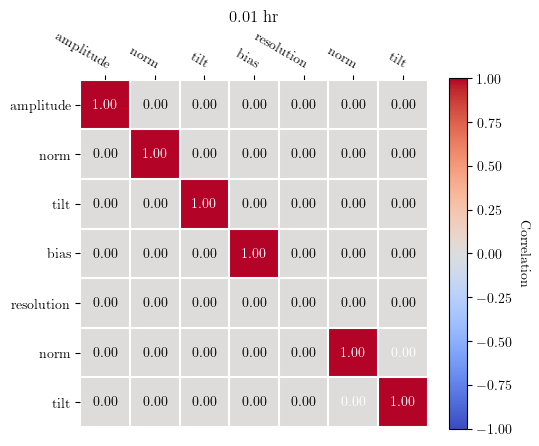

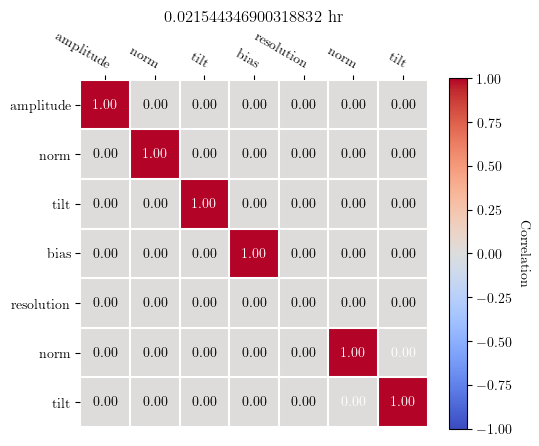

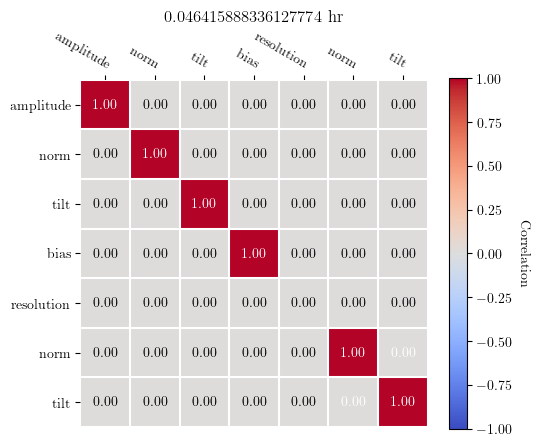

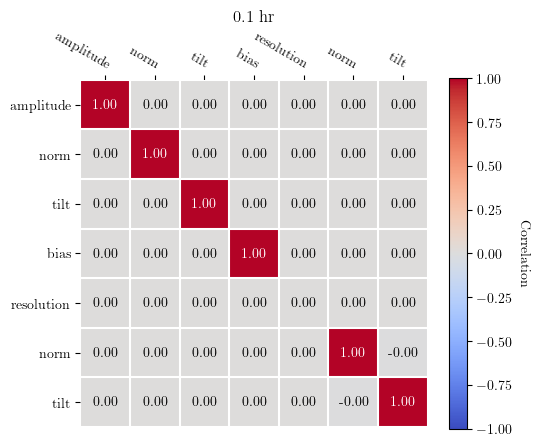

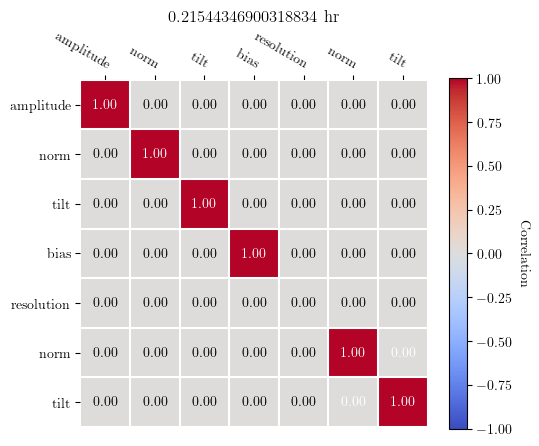

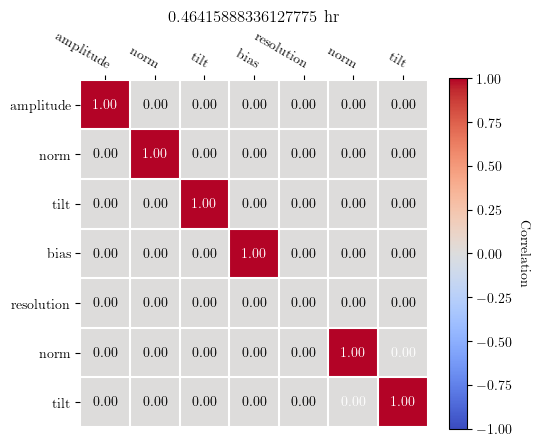

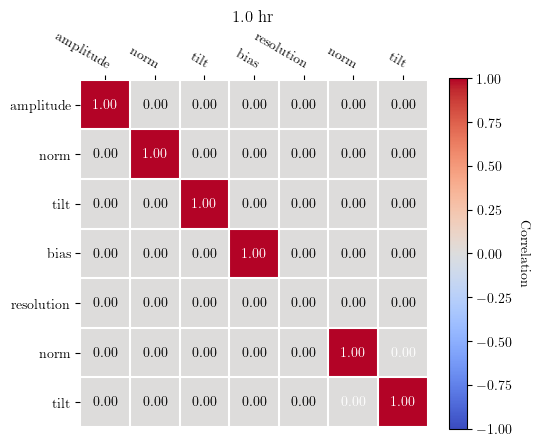

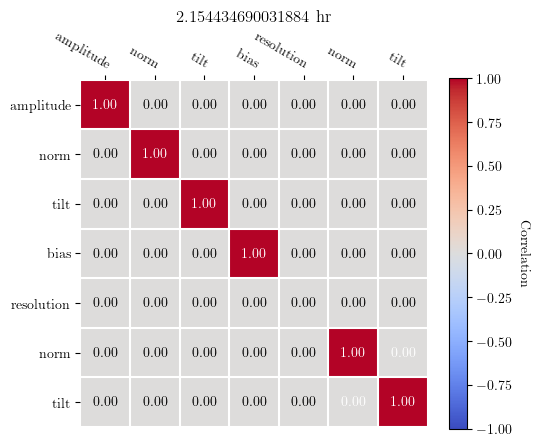

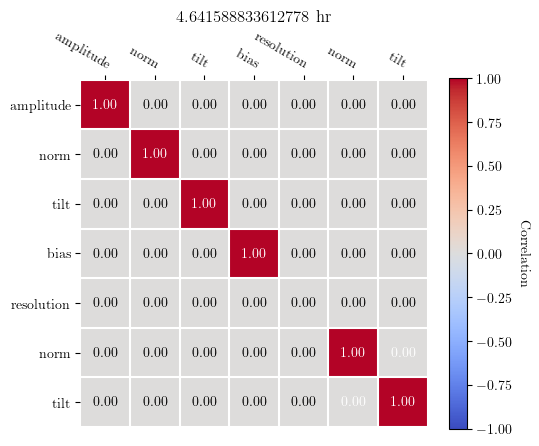

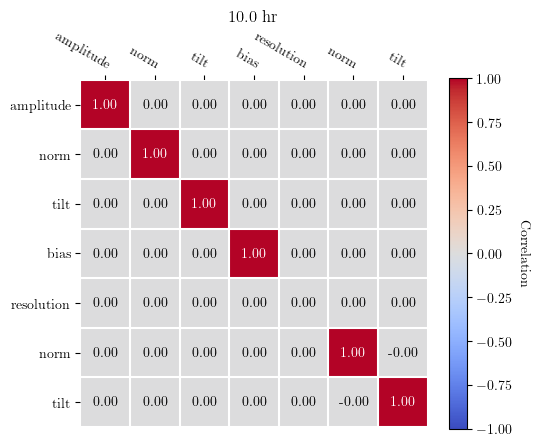

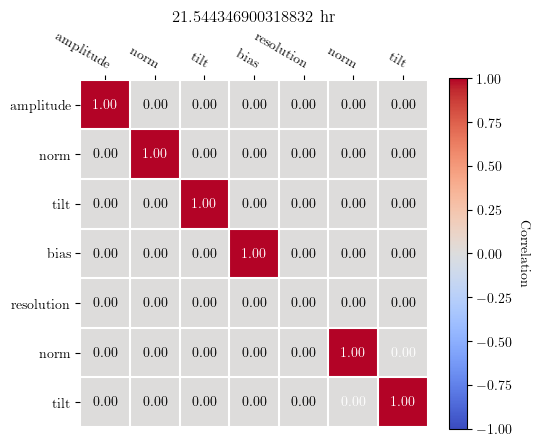

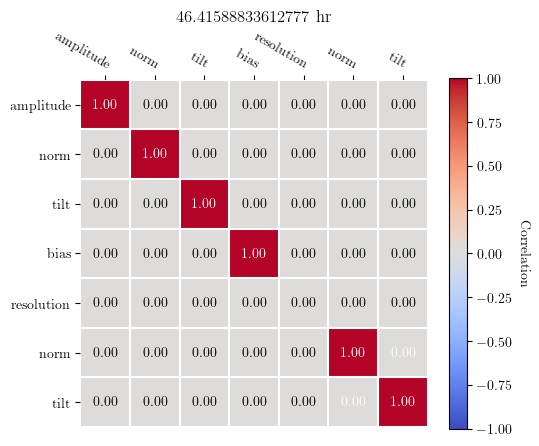

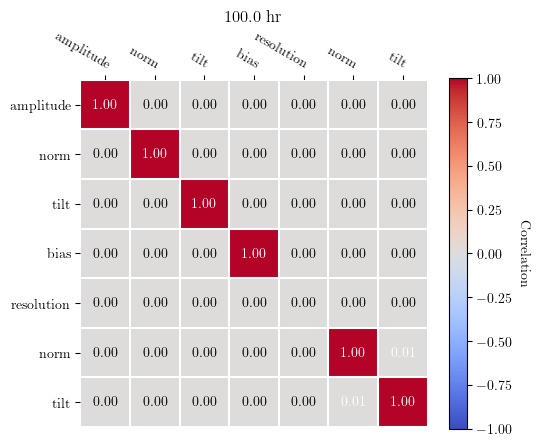

In [26]:
par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm' , 
            'tilt']
names =  ['index', 'amplitude',  
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']
for i in range(len(livetimes)):

    #datasets_N[i].models.read_covariance("data", f"8_model_nui_livetime_{livetimes[i]}_covariance.dat", format="ascii.fixed_width")
    parameters = Parameters([_ for _ in datasets_N[i].models.parameters if _.name in par_names])
    cov_par = datasets_N[i].models.covariance.get_subcovariance(parameters)
    ax = cov_par.plot_correlation()
    ax.set_title(str(livetimes[i]) + " hr")
    fig = plt.gcf()
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.svg')
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.pdf')
    


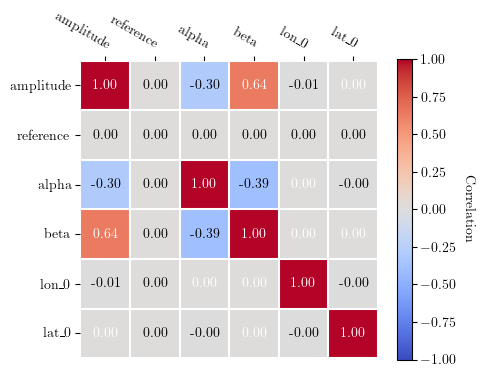

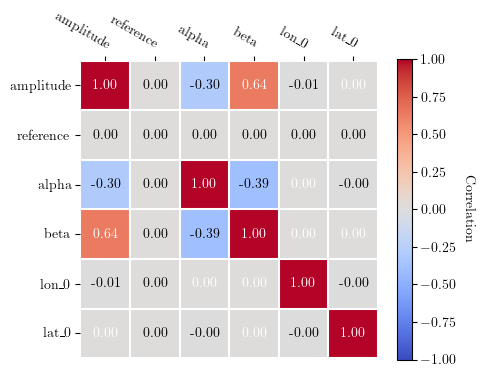

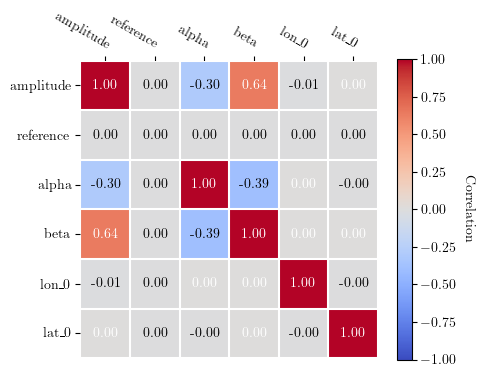

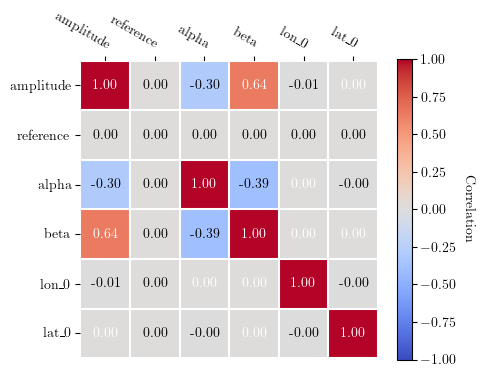

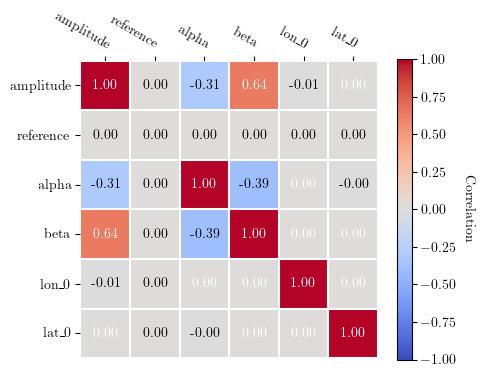

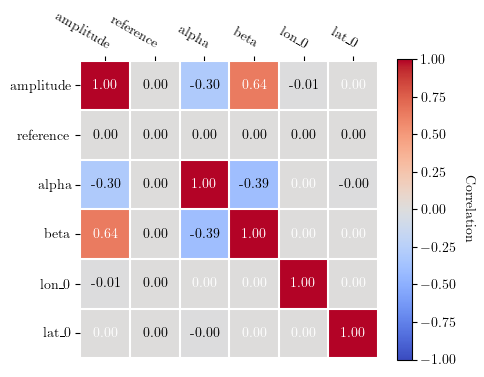

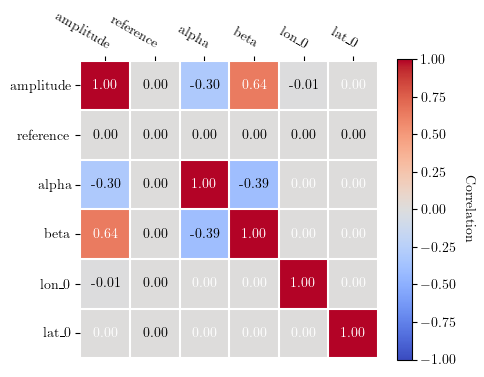

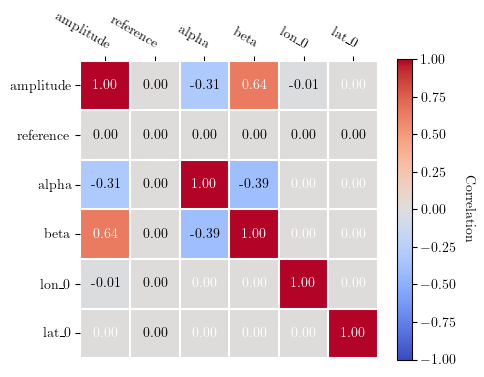

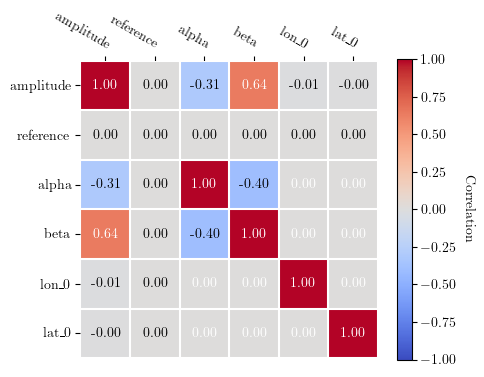

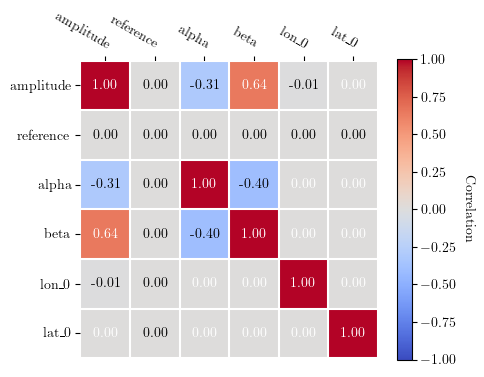

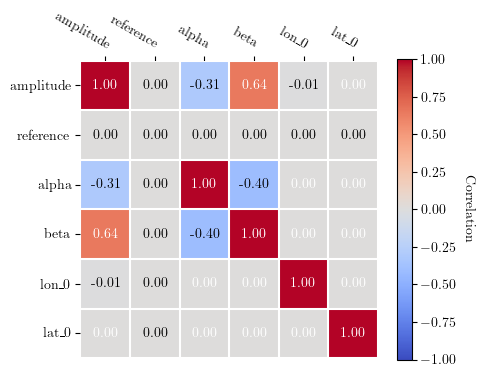

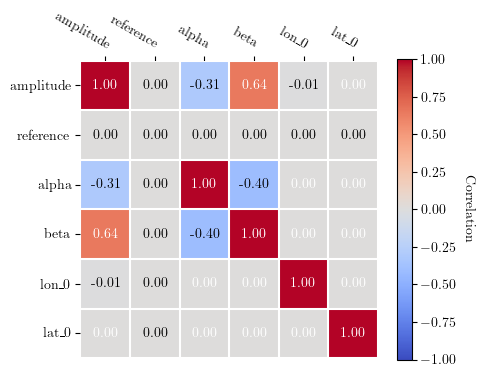

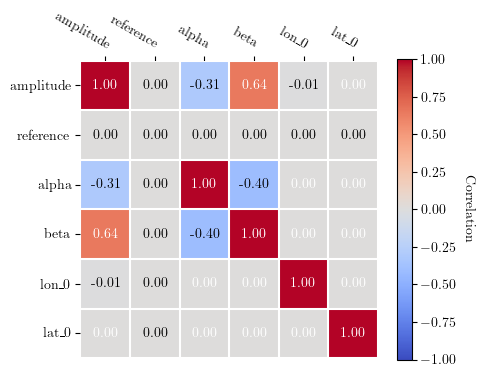

In [27]:
for d in datasets:
    d.models.covariance.plot_correlation()

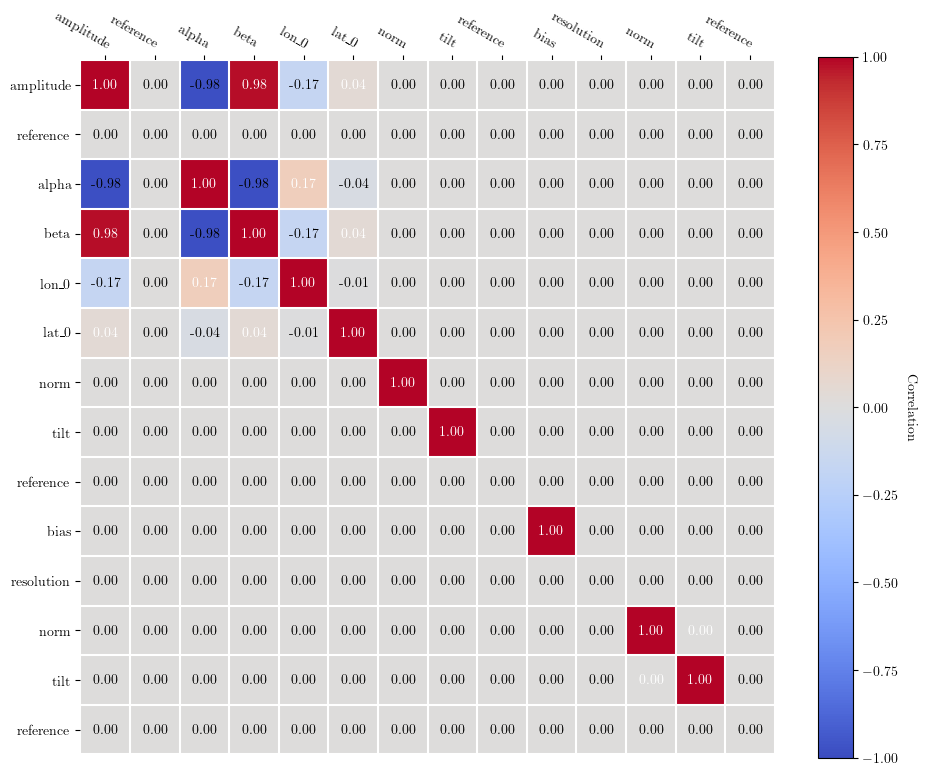

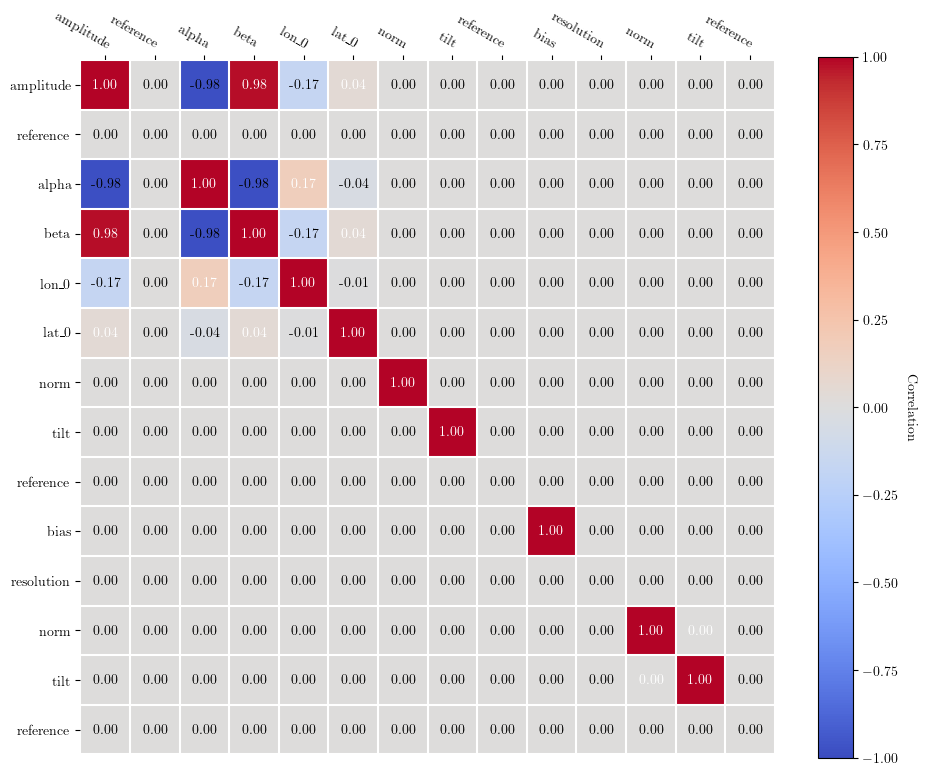

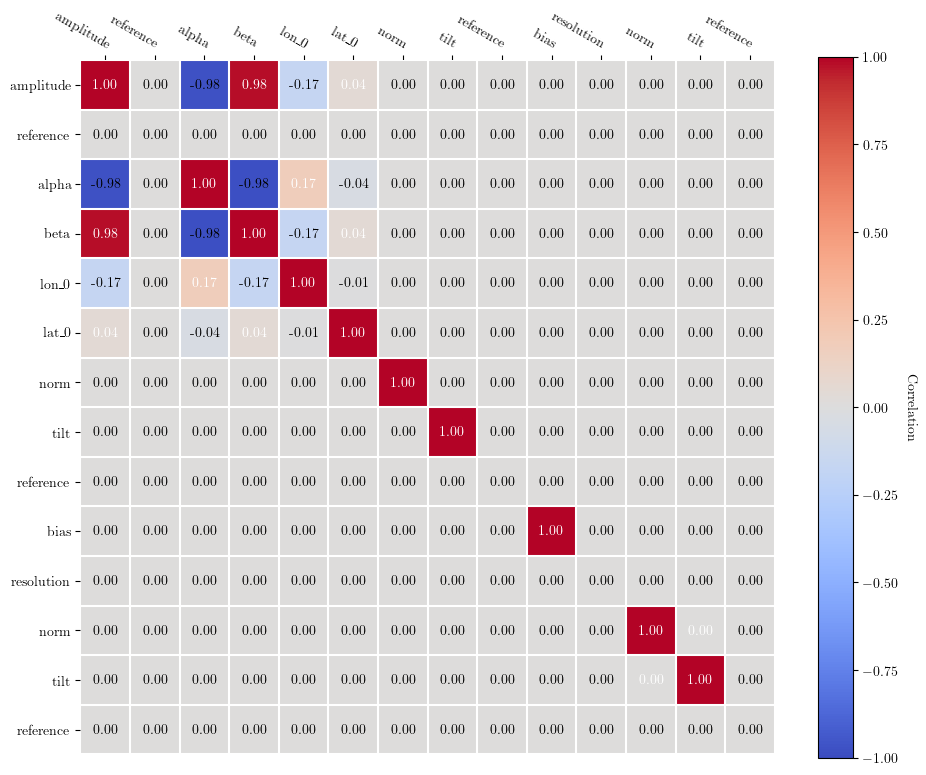

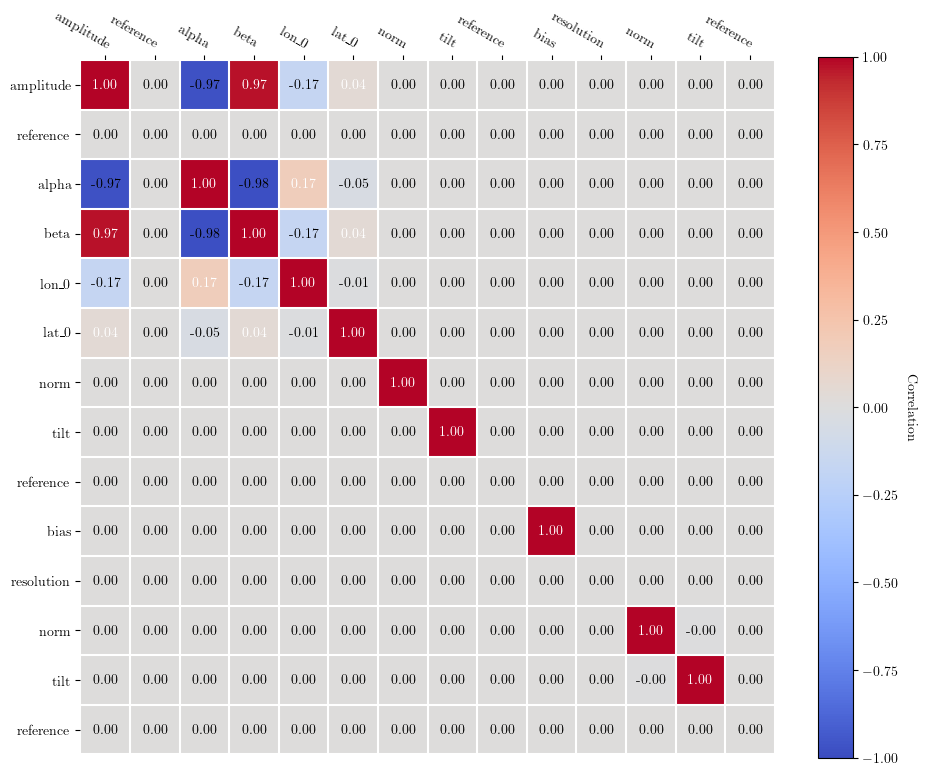

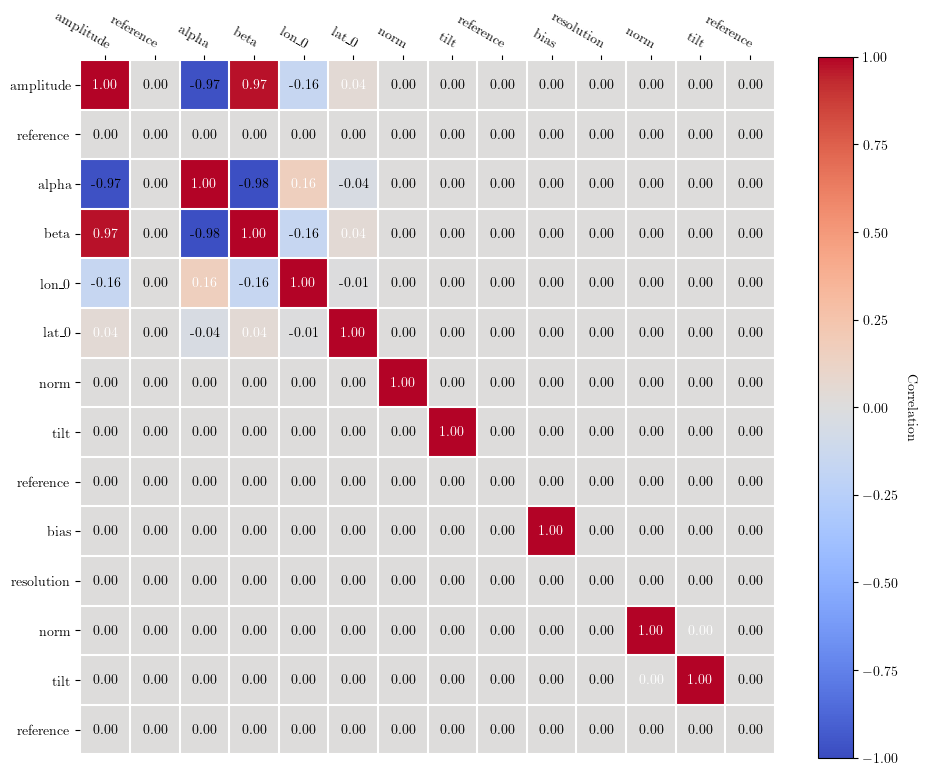

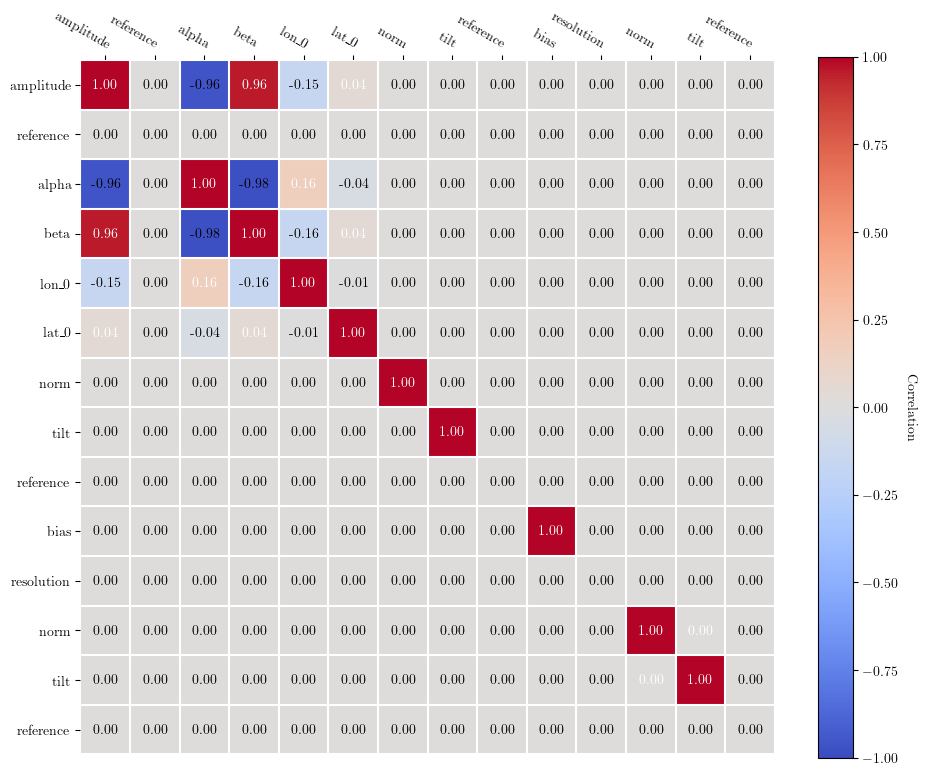

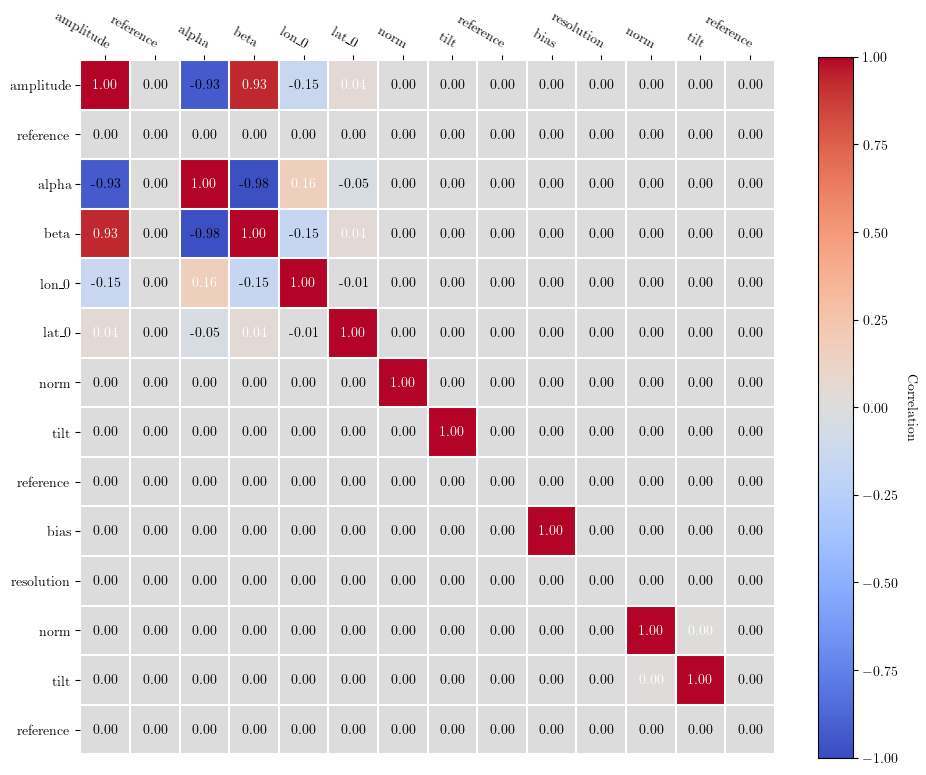

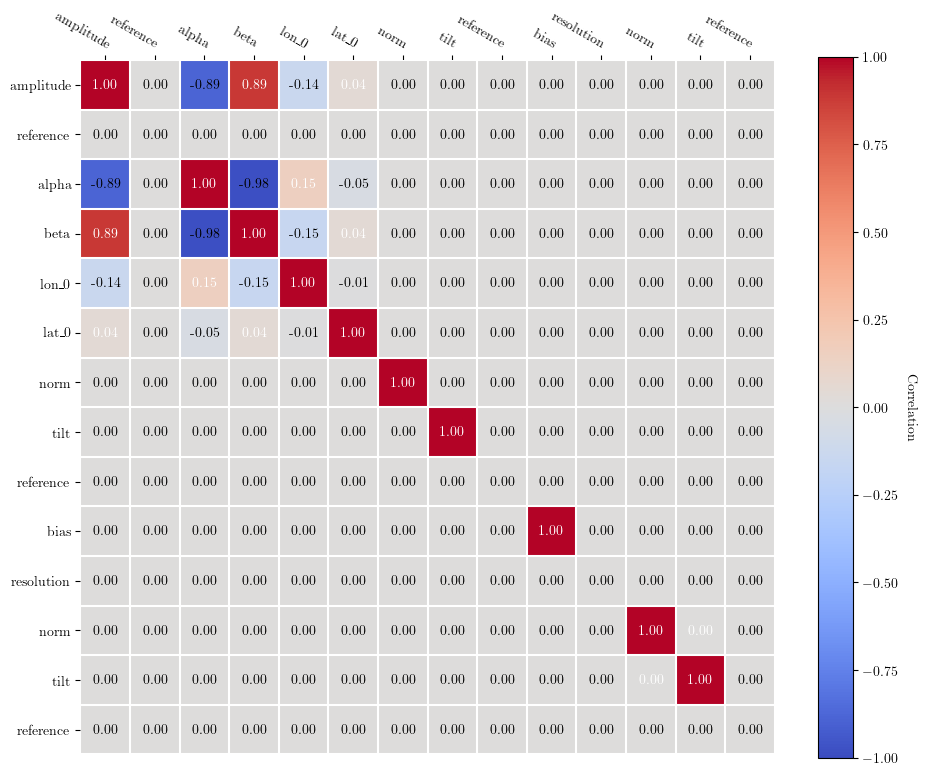

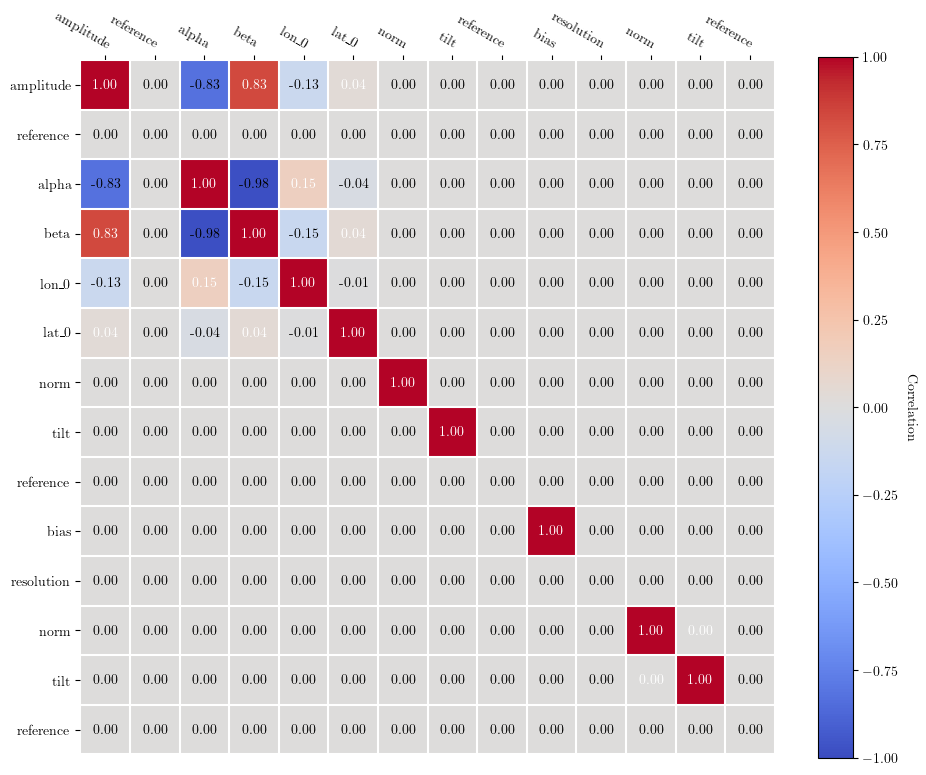

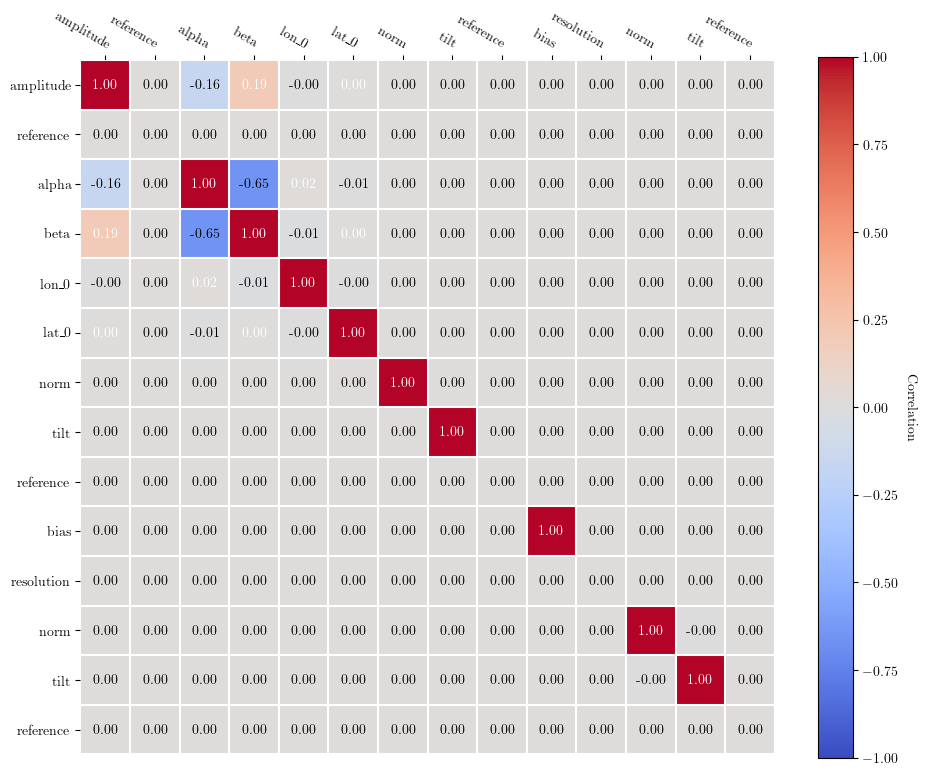

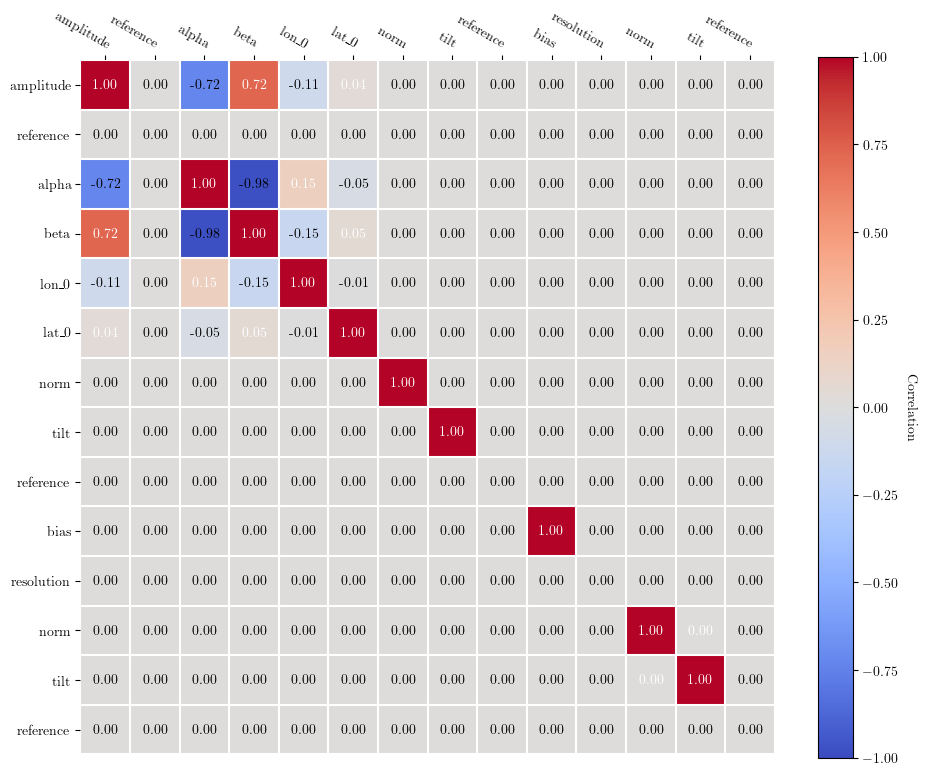

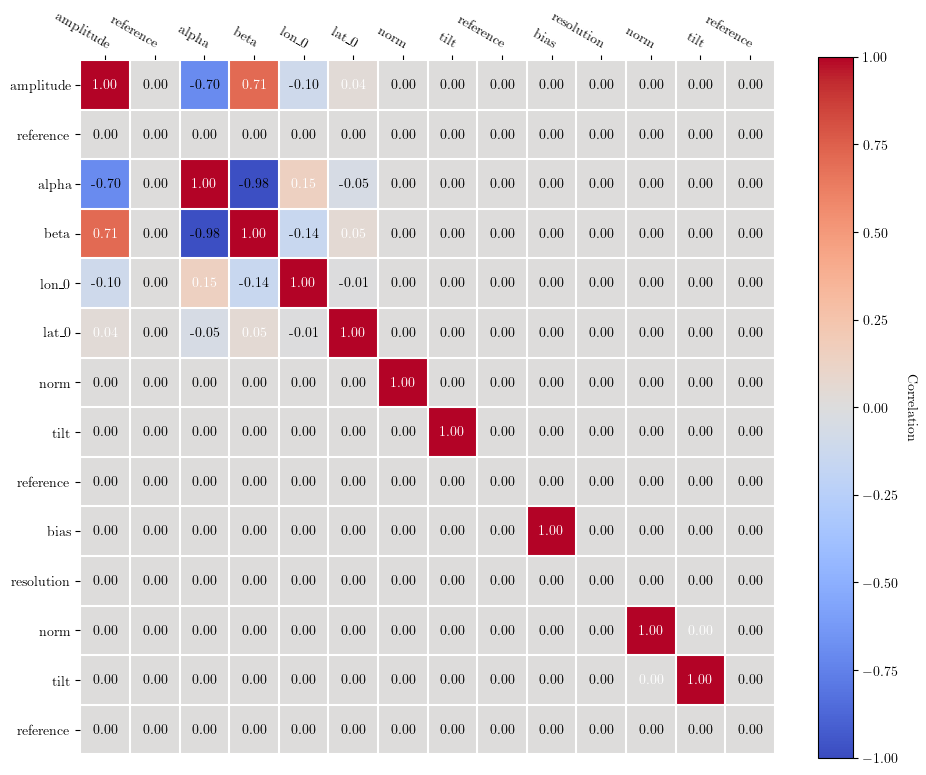

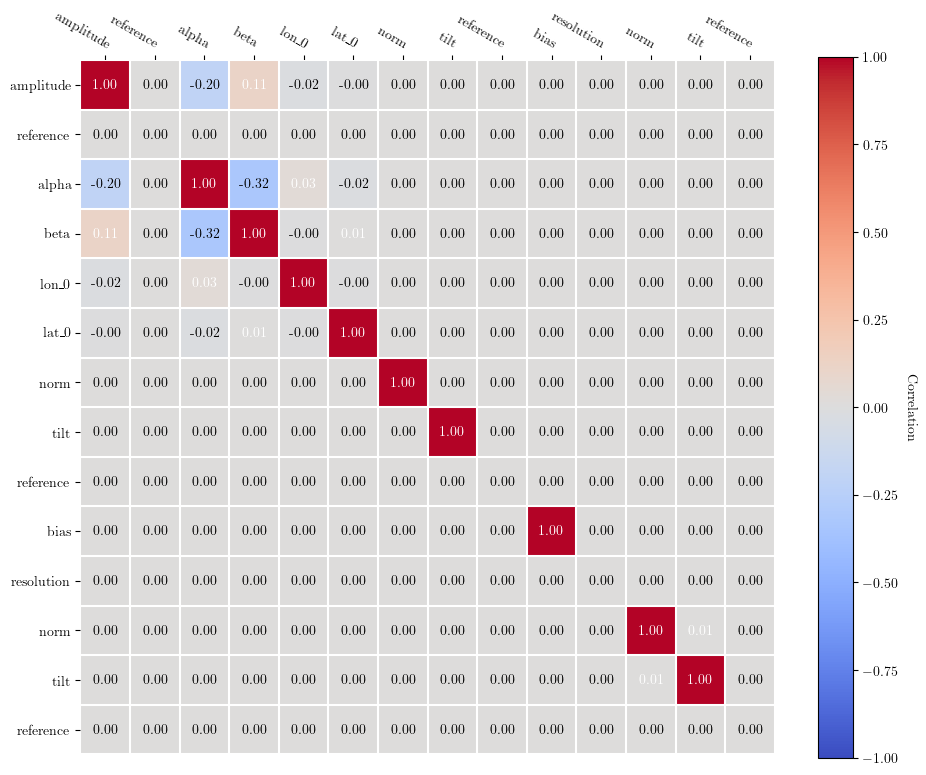

In [28]:
for d in datasets_N:
    d.models.covariance.plot_correlation()

In [29]:
print(datasets_N[7])

MapDataset
----------

  Name                            : kR0S1hkg 

  Total counts                    : 9817 
  Total background counts         : 8902.95
  Total excess counts             : 914.55

  Predicted counts                : 9816.41
  Predicted background counts     : 8902.95
  Predicted excess counts         : 913.46

  Exposure min                    : 3.39e-27 m2 s
  Exposure max                    : 2.74e+09 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 942469 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 89139.97

  Number of models                : 3 
  Number of parameters            : 14
  Number of free parameters       : 10

  Component 0: SkyModel
  
    Name                      : g2YhMcrW
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      ampli